### モジュールの読み込み

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import matplotlib

In [2]:
import seaborn as sns

In [3]:
import pymc3 as pm

/Users/kobarijun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### バージョンの確認

In [9]:
print('Running on Numpy v{}'.format(np.__version__))
print('Running on pandas v{}'.format(pd.__version__))
#print('Running on matplotlib v{}'.format(matplotlib__version__))
print('Running on seaborn v{}'.format(sns.__version__))
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on Numpy v1.14.0
Running on pandas v0.20.3
Running on seaborn v0.8.0
Running on PyMC3 v3.5


# データ

In [12]:
!ls

README.md                train.csv                ベイズモデル.ipynb


### データの読み込み

In [23]:
data=pd.read_csv('train.csv')
data.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


In [24]:
name=data.columns
name

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

### idは情報がないので削除

In [25]:
data.drop("id",axis=1,inplace=True)

### データの量が多すぎて私のPCではベイズモデルを実行するときに時間がかかり過ぎるのでデータ量を全体から3%までに減らします。

In [26]:
data=data.sample(frac=0.03,random_state=1)

# 基本統計量の確認

## 職業(job)と年齢(age)との予測変数の分布

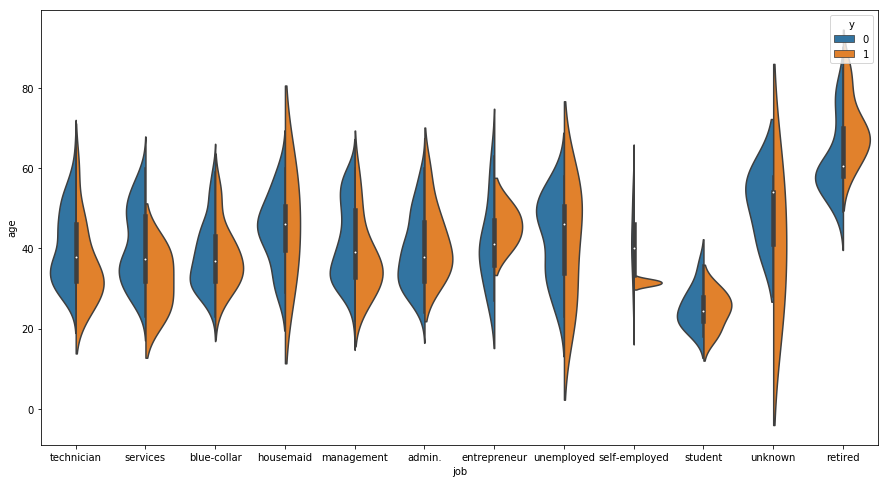

In [27]:
plt.figure(figsize=(15, 8))
sns.violinplot(x=data["job"], y =data["age"], hue=data['y'], split=True) 
plt.show()

### 　職業の違いよってあまり大きな変化は見られないが、学生(student)が少し膨らみが大きいのは、アルバイトなどの給料の振込や給料の振込のために準備したのかと考えられる。

## 予測変数(y)と未婚/既婚(marital)のモザイク図を作成

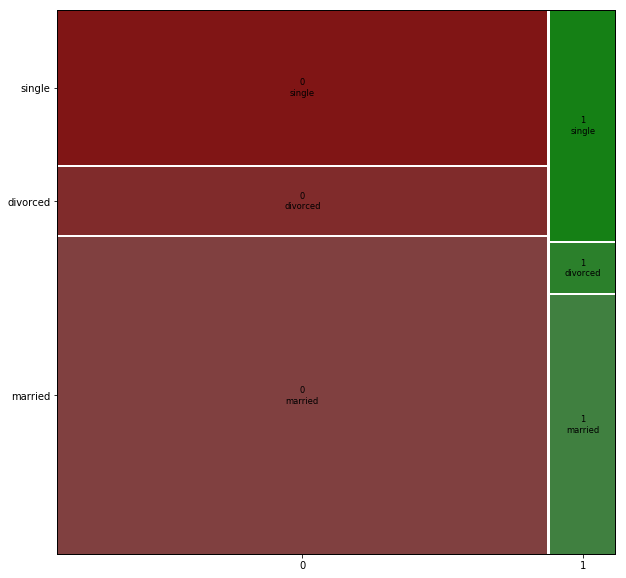

In [28]:
from statsmodels.graphics.mosaicplot import mosaic
from pylab import rcParams

rcParams['figure.figsize'] = 10,10
mosaic(data=data,index=['y','marital'])

plt.show()

### 結婚していると新しい講座を作る傾向にある。これは、結婚したことによって家計用の口座を作ろうとしたのだと思われる。

### 住宅ローン(housing)と予測変数(loan)とのモザイク図

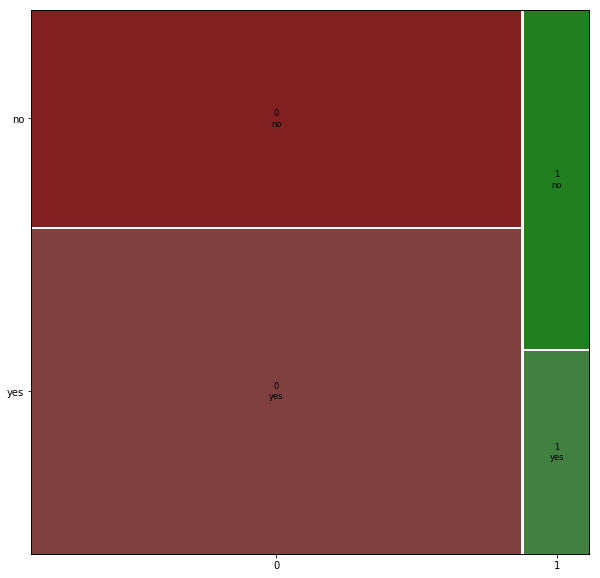

In [29]:
from pylab import rcParams

rcParams['figure.figsize'] = 10,10
mosaic(data=data,index=['y','housing'])

plt.show()

### 予測変数(y)と個人ローン(loan)

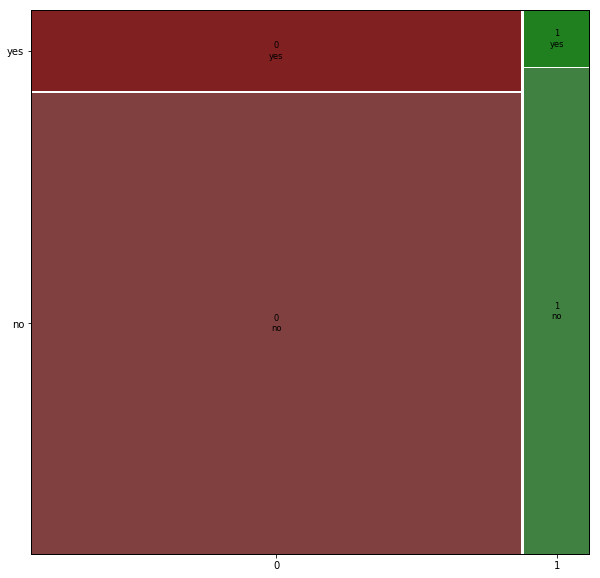

In [30]:
from pylab import rcParams

rcParams['figure.figsize'] = 10,10
mosaic(data=data,index=['y','loan'])

plt.show()

### 債務不履行(default)と予測変数(y)とのモザイク図

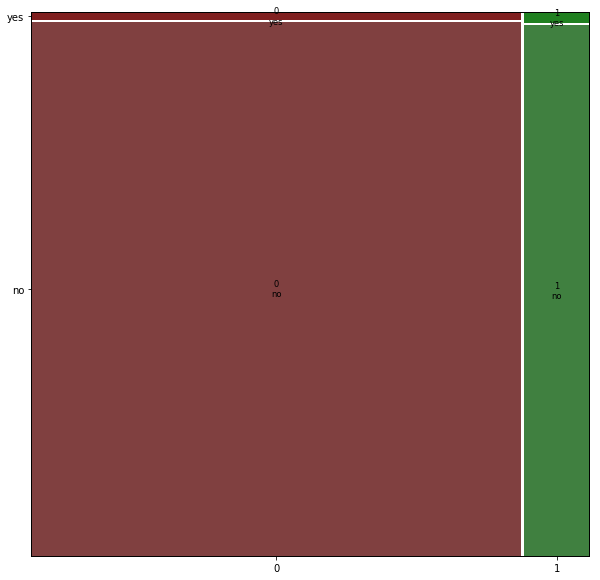

In [31]:
from pylab import rcParams

rcParams['figure.figsize'] = 10,10
mosaic(data=data,index=['y','default'])

plt.show()

### 最終接触月(month)と最終接触日(day)

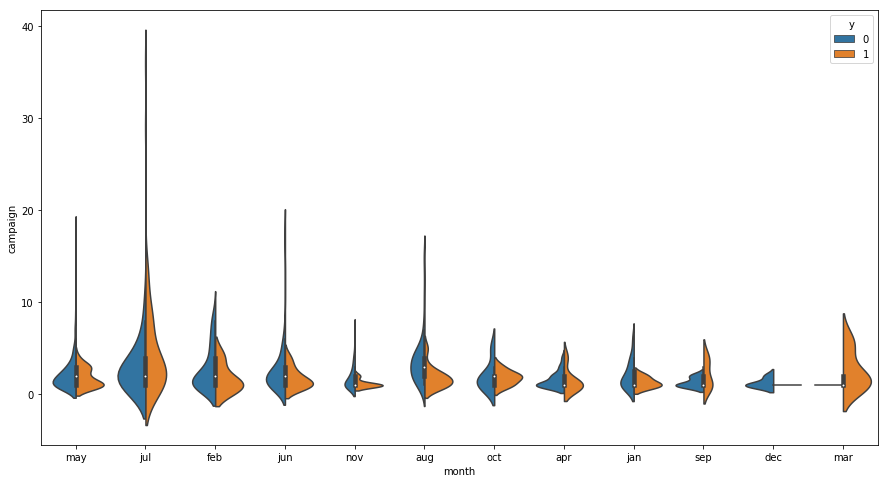

In [32]:
plt.figure(figsize=(15, 8))

sns.violinplot(x=data["month"], y =data["campaign"], hue=data['y'], split=True) 
plt.show()

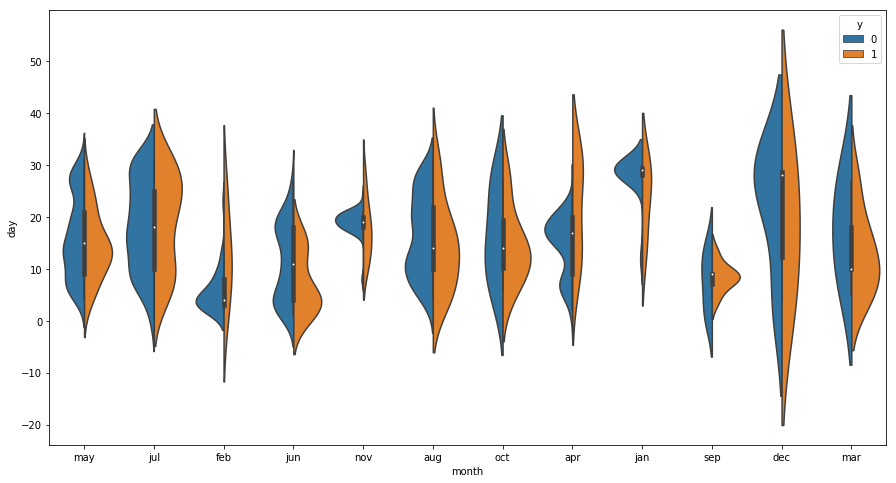

In [33]:
plt.figure(figsize=(15, 8))

sns.violinplot(x=data["month"], y =data["day"], hue=data['y'], split=True) 
plt.show()

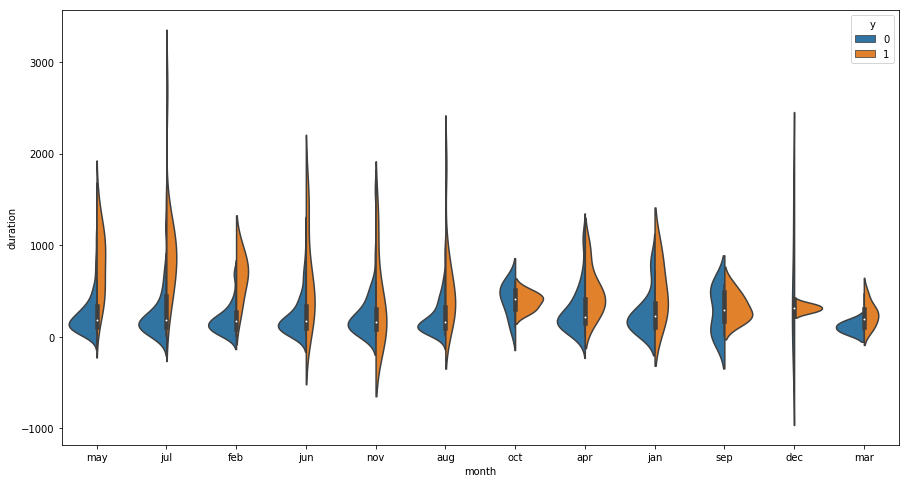

In [34]:
plt.figure(figsize=(15, 8))

sns.violinplot(x=data["month"], y =data["duration"], hue=data['y'], split=True) 
plt.show()

### 名義特徴量を一様値に変換する

In [35]:
data=pd.get_dummies(data)

In [36]:
name=data.columns
name

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

### 説明変数

In [37]:
X=data.loc[:,data.columns != 'y']
X.shape

(814, 51)

In [38]:
X=pd.get_dummies(X)
X.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
25843,49,6050,14,229,2,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1703,32,-115,16,134,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
7434,40,286,30,106,4,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9145,40,1674,4,144,1,274,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4679,60,4903,9,290,1,-1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


### 標準化

In [39]:
from sklearn.preprocessing import StandardScaler

stdsc=StandardScaler()
X=stdsc.fit_transform(X)

In [40]:
X.shape

(814, 51)

### 予測変数

In [41]:
y=data.loc[:,data.columns == 'y']
y.head()

,y
25843,0
1703,0
7434,0
9145,0
4679,0


In [42]:
y.shape

(814, 1)

## モデル

#### モデル1(事前分布:正規分布)

In [45]:
#モデルを定義する
with pm.Model() as model_1:
    
    #事前分布
    alpha=pm.Normal('alpha',mu=0,sd=100)
    beta=pm.Normal('beta',mu=0,sd=100,shape=X.shape[1])
    
    #線形予測の定義　α+βX
    mu=alpha+pm.math.dot(X,beta)
 #   theta=pm.Deterministic('theta',1/(1+pm.math.exp(-mu)))
    
    y1=pm.Bernoulli('y1',p=1/(1+pm.math.exp(-mu)),observed=y)

In [44]:
with model_1:
    start=pm.find_MAP()
    step=pm.Metropolis()
    trace=pm.sample(15000,step=step,start=start,chains=2)

logp = -4.5956e+05, ||grad|| = 2.5315e+05: 100%|██████████| 9/9 [00:00<00:00, 59.09it/s]   
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 31000/31000 [05:37<00:00, 91.75draws/s] 
/Users/kobarijun/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/kobarijun/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler

In [46]:
pm.summary(trace)

/Users/kobarijun/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/kobarijun/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-2.012284,0.003761,0.000109,-2.019065,-2.004620,1176.866652,1.000005
beta__0,-0.000847,0.004723,0.000360,-0.010027,0.008441,83.670844,1.001801
beta__1,-0.000355,0.003871,0.000246,-0.008254,0.006814,185.669536,1.001745
beta__2,-0.000247,0.004628,0.000350,-0.009286,0.008494,90.921727,1.008785
beta__3,0.000092,0.004096,0.000262,-0.007664,0.008263,167.608364,1.003835
beta__4,0.000588,0.003910,0.000271,-0.007396,0.007763,160.337312,1.000079
beta__5,0.002824,0.007667,0.000688,-0.013193,0.017235,14.826939,1.100009
beta__6,0.000944,0.006424,0.000557,-0.013613,0.012783,33.718052,1.002699
beta__7,-0.001290,0.012831,0.001249,-0.020512,0.024259,2.238661,1.529572
beta__8,-0.001572,0.017526,0.001724,-0.027921,0.032405,1.890546,1.673613


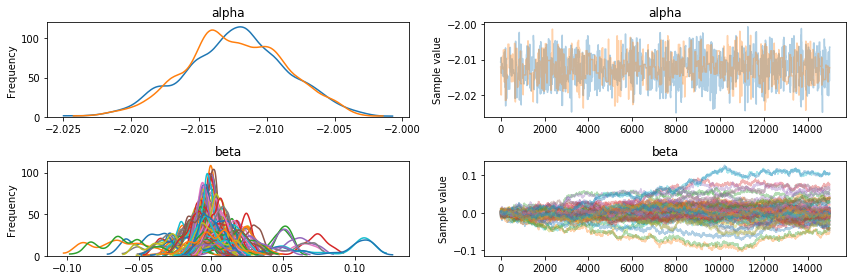

In [47]:
pm.traceplot(trace)
plt.show()

#### モデル2(事前分布:ベータ分布(α=1,β=1)

In [48]:
#モデルを定義する
with pm.Model() as model_2:
    
    #事前分布
    alpha=pm.Beta('alpha',alpha=1,beta=1)
    beta=pm.Beta('beta',alpha=1,beta=1,shape=X.shape[1])
    
    #線形予測の定義　α+βX
    mu=alpha+pm.math.dot(X,beta)
 #   theta=pm.Deterministic('theta',1/(1+pm.math.exp(-mu)))
    
    y1=pm.Bernoulli('y1',p=1/(1+pm.math.exp(-mu)),observed=y)

In [49]:
with model_2:
    start=pm.find_MAP()
    step=pm.Metropolis()
    trace=pm.sample(15000,step=step,start=start,chains=2)

logp = -4.5928e+05, ||grad|| = 5.1081: 100%|██████████| 54/54 [00:00<00:00, 62.14it/s]     
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 31000/31000 [05:05<00:00, 101.46draws/s]
/Users/kobarijun/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/kobarijun/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler

### トレース

In [181]:
pm.summary(trace)

/Users/kobarijun/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/kobarijun/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,4.006633e-06,3.941629e-06,5.142250e-08,3.817675e-10,1.211862e-05,6420.239254,0.999987
beta__0,2.892990e-06,3.679722e-07,3.666781e-08,2.238245e-06,3.620990e-06,2.193862,1.594546
beta__1,8.652328e-07,5.958147e-08,5.876468e-09,7.480984e-07,9.771699e-07,2.181688,1.630895
beta__2,1.308859e-06,1.792183e-07,1.786110e-08,1.030871e-06,1.712826e-06,2.227990,1.658141
beta__3,2.773077e-07,2.293680e-08,2.275190e-09,2.279881e-07,3.118812e-07,4.927855,1.105606
beta__4,2.840028e-07,2.707038e-08,2.687913e-09,2.454629e-07,3.441218e-07,1.718421,1.869024
beta__5,1.718738e-06,1.402452e-07,1.390935e-08,1.483536e-06,1.987703e-06,5.517822,1.002718
beta__6,1.009301e-06,8.229317e-08,8.148864e-09,8.680351e-07,1.146369e-06,1.445199,2.092930
beta__7,5.063457e-01,5.965021e-03,5.608642e-04,4.958727e-01,5.182066e-01,9.870247,1.015348
beta__8,6.199526e-01,7.164347e-03,6.871738e-04,6.075588e-01,6.345680e-01,9.094784,1.008730


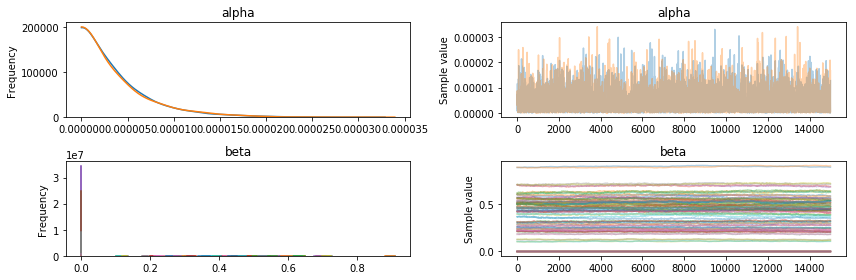

In [182]:
pm.traceplot(trace)
plt.show()

##### モデル2よりモデル1の方がいい感じではある。

### データ間の相関関係

In [52]:
corr=data.corr()

In [53]:
fig, ax = plt.subplots(figsize=(52, 52)) 
sns.heatmap(corr, square=True, vmax=1, vmin=-1, center=0)

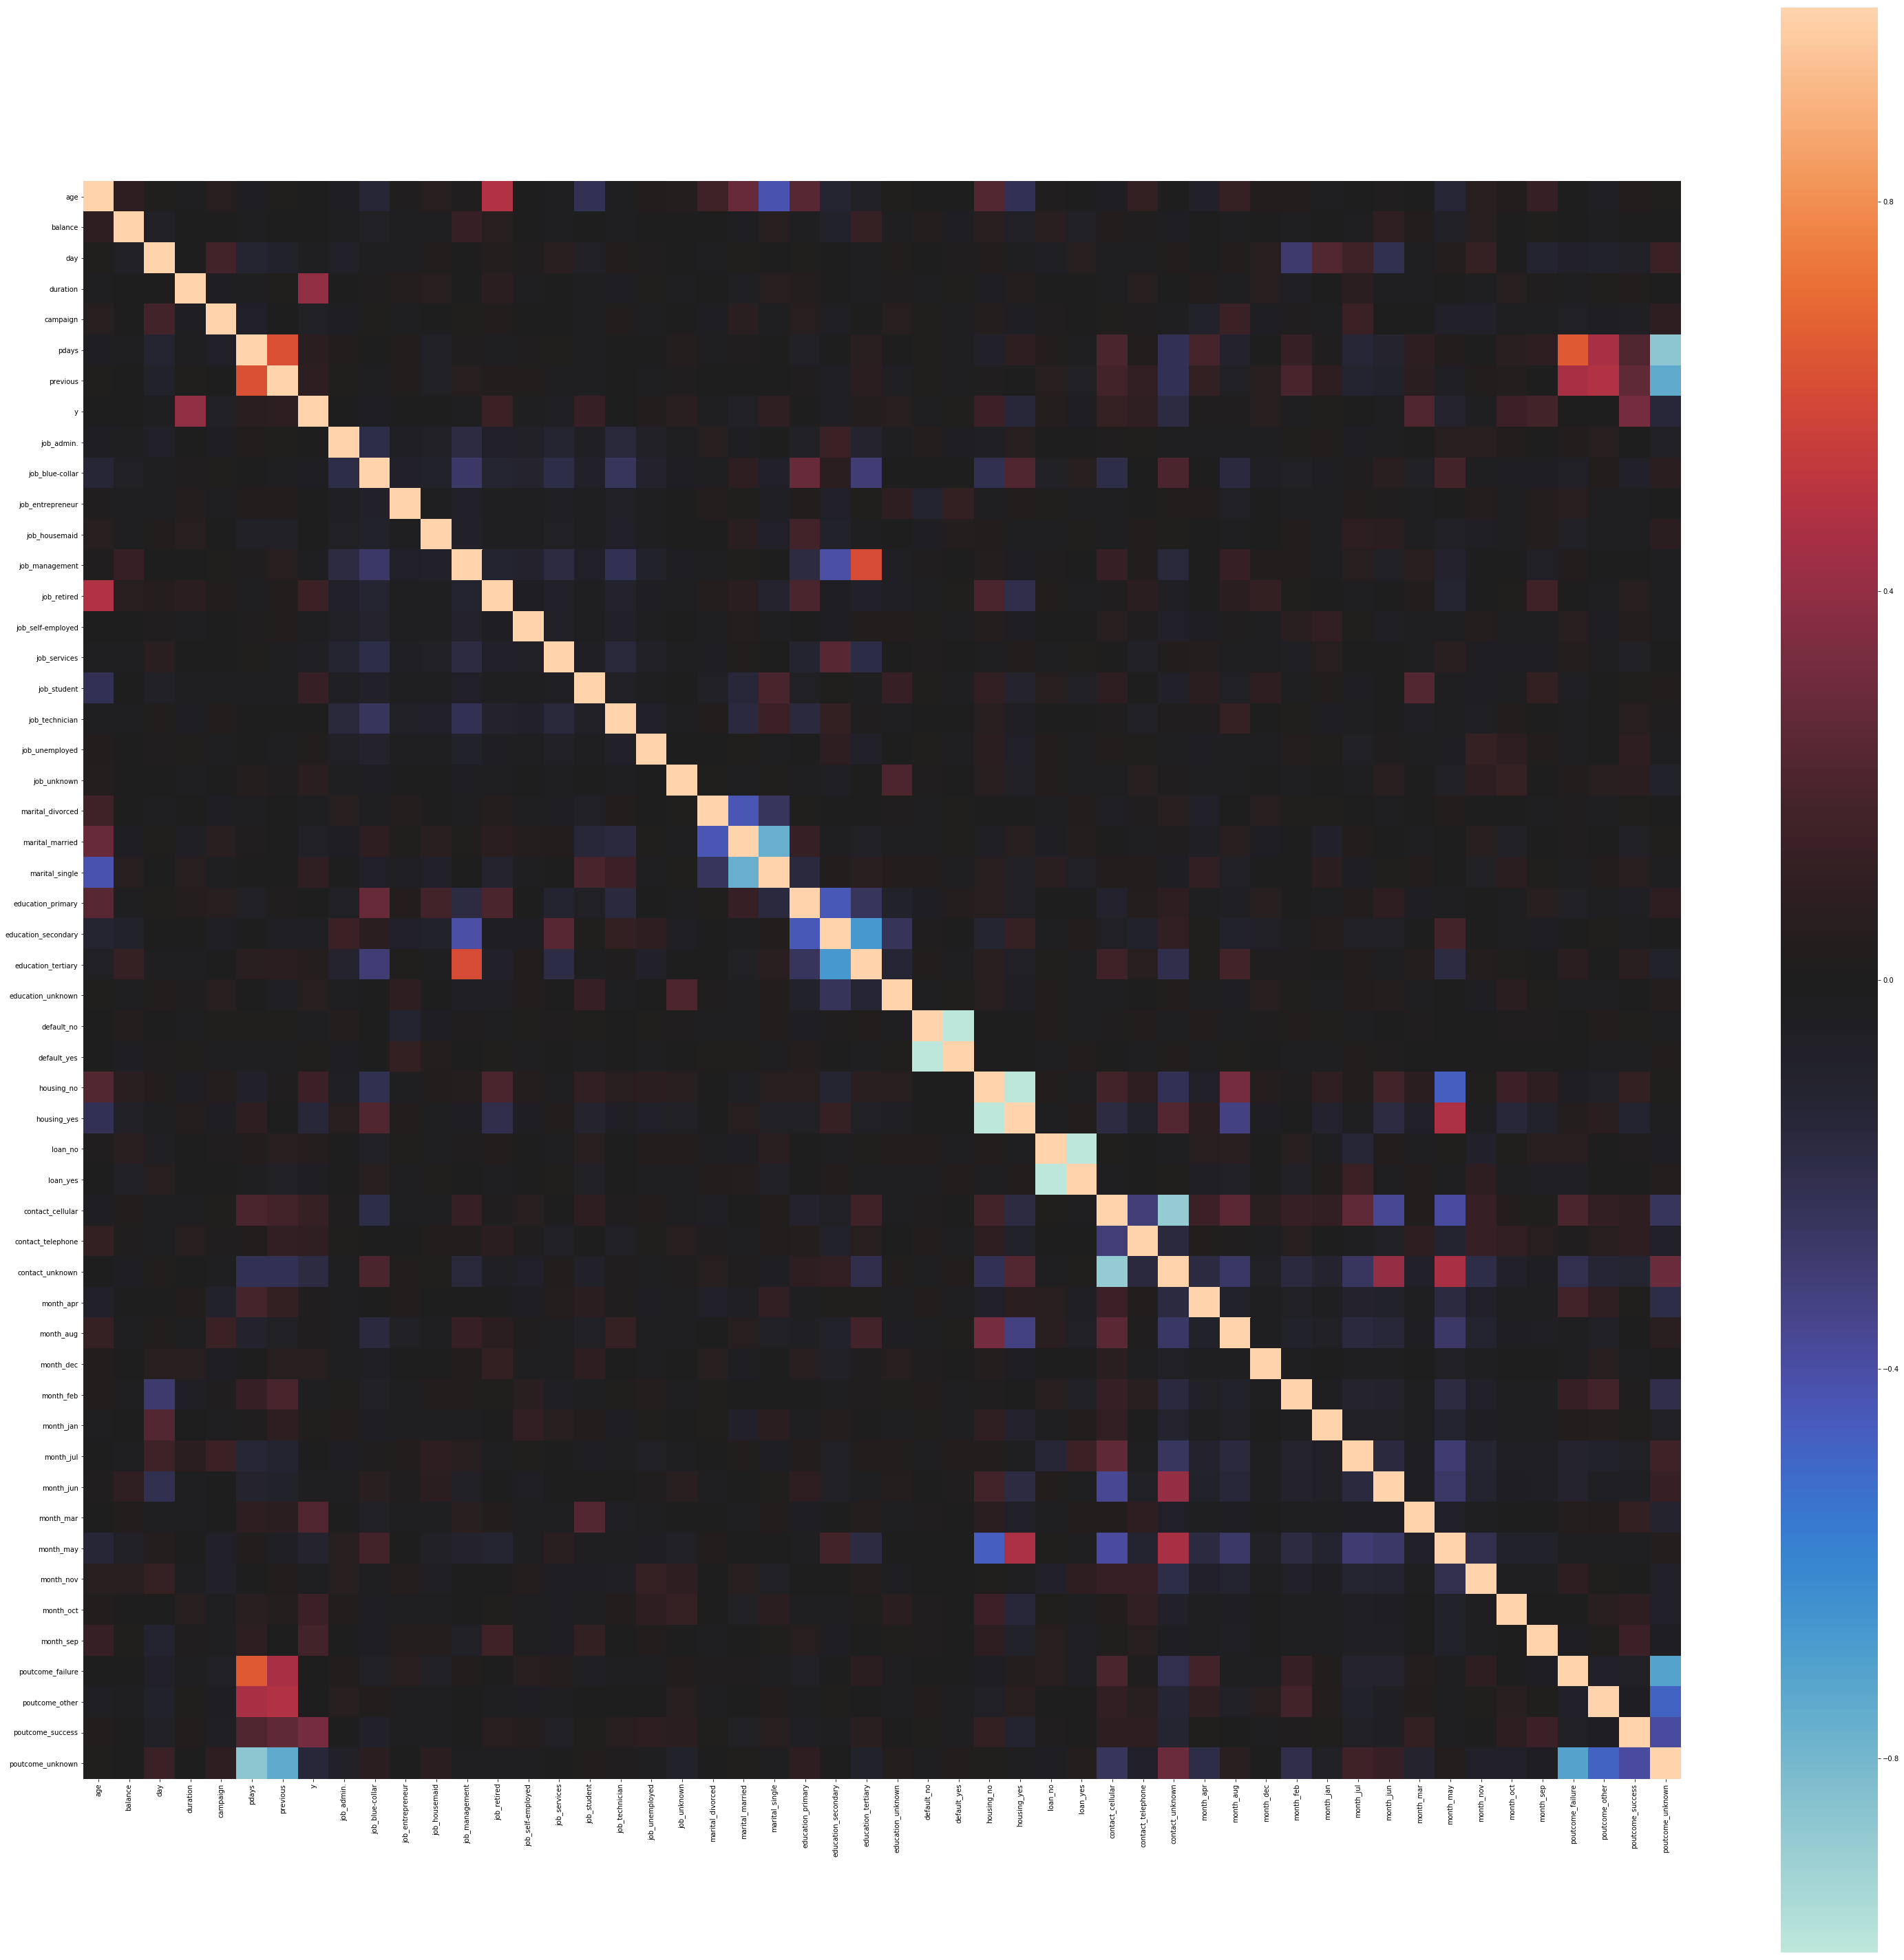

In [54]:
plt.savefig('/Users/kobarijun/Desktop/heatmap.png')
plt.show()